In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from analysis_tools.workflows.evaluation_flow import evaluation_flow
from analysis_tools.workflows.BDT_pipeline import run_bdt_pipeline
from analysis_tools.namings.BDT_feature_naming import BDT_feature_name_change
from analysis_tools.BDT_tools.Testset_preparation import create_learning_input,annotate_labels
from analysis_tools.BDT_tools.BDT_evaluation import find_best_two_bdt_thresholds,plot_bdt_threshold_scan
from analysis_tools.workflows.prediction_flow import prediction_flow,predict_scores
from analysis_tools.my_selectors.apply_selection import apply_selection
import pickle, sys, os


/data/user/tvaneede/software/py_venvs/py3-v4.4.1_reco-v1.1.0/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [3]:
output_dir = "/data/user/tvaneede/GlobalFit/reco_processing/bdt/notebooks/optimize_bdt/combine_datasets"
os.system(f"mkdir -p {output_dir}")

0

In [4]:
sys.path.append("/data/user/tvaneede/GlobalFit/reco_processing/bdt/training/optimize_training/")
from features_list_dict import features_list_dict

In [5]:
datasets_path = "/data/user/tvaneede/GlobalFit/reco_processing/NNMFit/datasets/flavor_globalfit/hese/combined/"

df_1 = pd.read_parquet(f"{datasets_path}/IC86_pass2_SnowStorm_v2_FTP_Baseline_hdf-v7_noMuon/dataset_IC86_pass2_SnowStorm_v2_FTP_Baseline_hdf-v7_noMuon.parquet")
df_2 = pd.read_parquet(f"{datasets_path}/IC86_pass2_SnowStorm_v2_FTP_Baseline_Extra_hdf-v1_noMuon/dataset_IC86_pass2_SnowStorm_v2_FTP_Baseline_Extra_hdf-v1_noMuon.parquet")

In [6]:
per_flavor_norm = 2.12
gamma_astro = 2.87
norm_factor = 0.5 * per_flavor_norm * 1e-18
livetime = 12*365.25*24*3600
for df in (df_1, df_2):
    e = df["MCPrimaryEnergy"] / 1e5
    df["fluxless_weight"] = df["powerlaw"] * 1e18 * e**2
    df["weight"] = df["fluxless_weight"] * norm_factor * e**(-gamma_astro)*livetime

In [7]:
feature_name = "11features_plus_rloglmilli_econf_evtgen"

model_name = f"mcd-simpletopology_flux-hese_feat-{feature_name}"
features = features_list_dict[feature_name]

model_path = "/data/user/tvaneede/GlobalFit/reco_processing/bdt/training/optimize_training"

model1_path = f"{model_path}/output/{model_name}/train"
model2_path = f"{model_path}/output_extra_train_sample/{model_name}/train"

Lets first try evaluation the BDT model trained on dataset 1, both on dataset 1 and 2. Is it much better on dataset 1 than on dataset 2? 

Results each dataset when I apply model trained on dataset1:
- Dataset1
    - ROC1 = 0.547, ROC2 = 0.614
    - Post tau rate = 4.48388
    - Efficiency = 0.13
- Dataset2
    - ROC1 = 0.545, ROC2 = 0.612
    - Post tau rate = 4.244
    - Efficiency = 0.124

In [9]:
with open(f'{model1_path}/bdt1_model.pkl',"rb") as f:
        bdt1 = pickle.load(f)
with open(f'{model1_path}/bdt2_model.pkl',"rb") as f:
        bdt2 = pickle.load(f)
        
models = {'bdt1': bdt1, 'bdt2': bdt2}
thresholds = {'bdt1_score': 0.366667, 'bdt2_score': 0.5}


=== Pre-BDT rates ===
Calculating rates for flavor: nue
Raw event count: 140651
[weight] rate        = 58.2824
[weight] uncertainty = 0.382952
Calculating rates for flavor: numu
Raw event count: 98543
[weight] rate        = 21.1283
[weight] uncertainty = 0.15723
Calculating rates for flavor: nutau
Raw event count: 131253
[weight] rate        = 34.3722
[weight] uncertainty = 0.27509


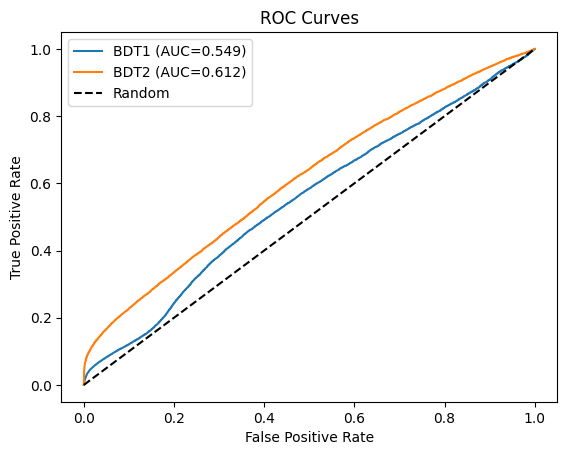

saving roc curves


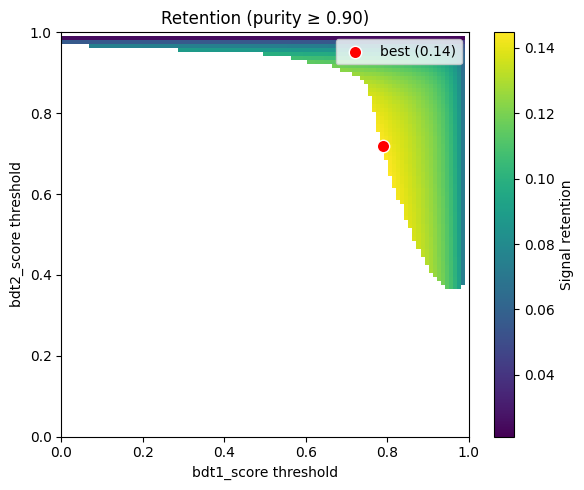


=== Post-BDT rates ===
Calculating post-BDT rates for flavor: nue
Raw event count: 2116
[weight] rate        = 0.379662
[weight] uncertainty = 0.0193611
Calculating post-BDT rates for flavor: numu
Raw event count: 3243
[weight] rate        = 0.167916
[weight] uncertainty = 0.00807608
Calculating post-BDT rates for flavor: nutau
Raw event count: 44066
[weight] rate        = 4.97586
[weight] uncertainty = 0.0710936


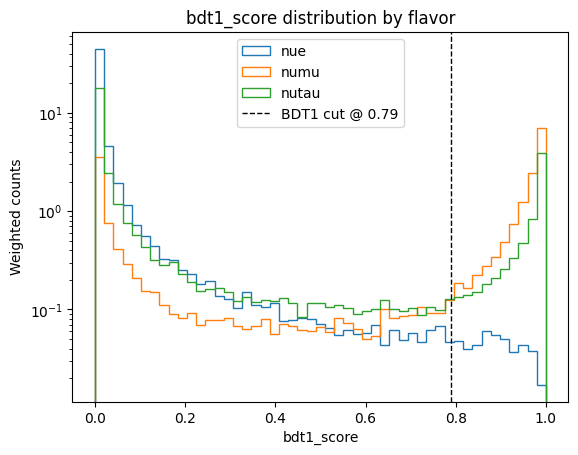

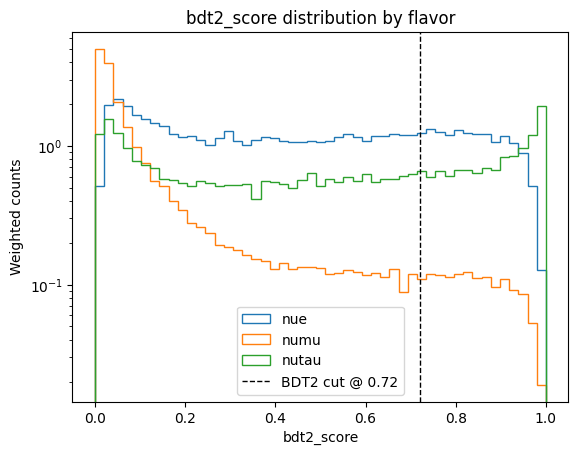

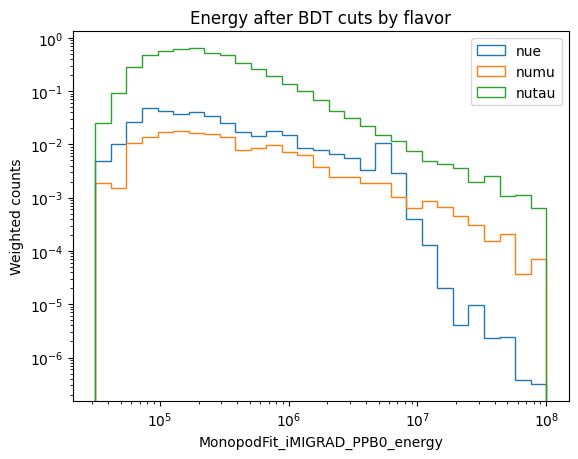


Final purity: 0.901, efficiency: 0.145


In [10]:
df1_with_scores = prediction_flow(
    df_1,
    models,
    features,
    thresholds=thresholds
)

summary = evaluation_flow(
    df1_with_scores, 
    model1 = bdt1,
    model2 = bdt2, 
    features = features,
    weight_col = 'weight',
    precut_criteria={},
    purity_target=0.90,
    output_dir=f'{output_dir}/eval1_model1'
)


=== Pre-BDT rates ===
Calculating rates for flavor: nue
Raw event count: 135701
[weight] rate        = 59.0596
[weight] uncertainty = 0.401905
Calculating rates for flavor: numu
Raw event count: 79176
[weight] rate        = 21.3634
[weight] uncertainty = 0.163682
Calculating rates for flavor: nutau
Raw event count: 113478
[weight] rate        = 34.1871
[weight] uncertainty = 0.282572


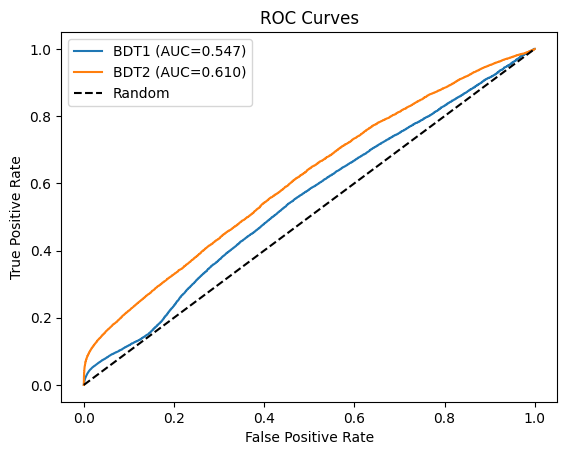

saving roc curves


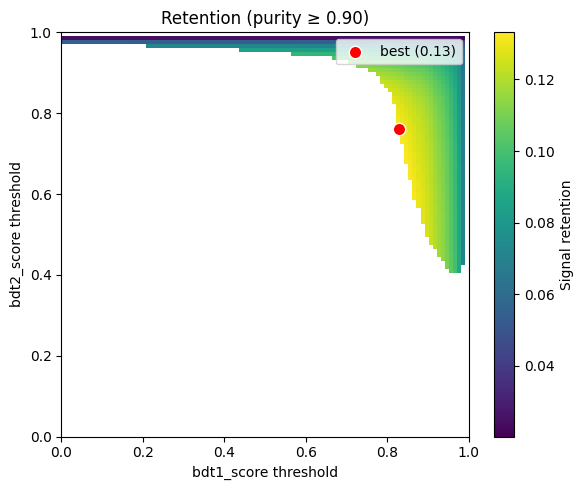


=== Post-BDT rates ===
Calculating post-BDT rates for flavor: nue
Raw event count: 1631
[weight] rate        = 0.339532
[weight] uncertainty = 0.0198524
Calculating post-BDT rates for flavor: numu
Raw event count: 2168
[weight] rate        = 0.160553
[weight] uncertainty = 0.00916557
Calculating post-BDT rates for flavor: nutau
Raw event count: 35068
[weight] rate        = 4.5519
[weight] uncertainty = 0.0683622


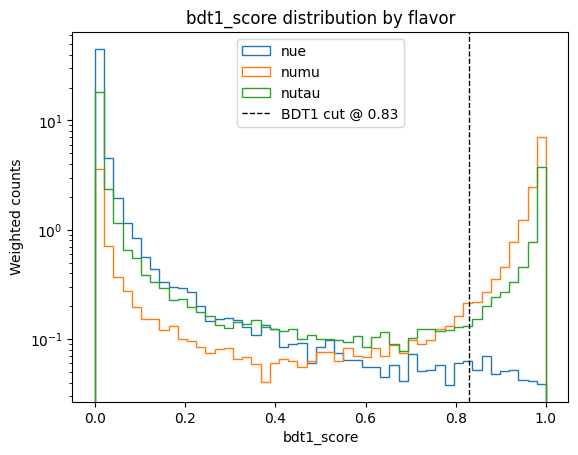

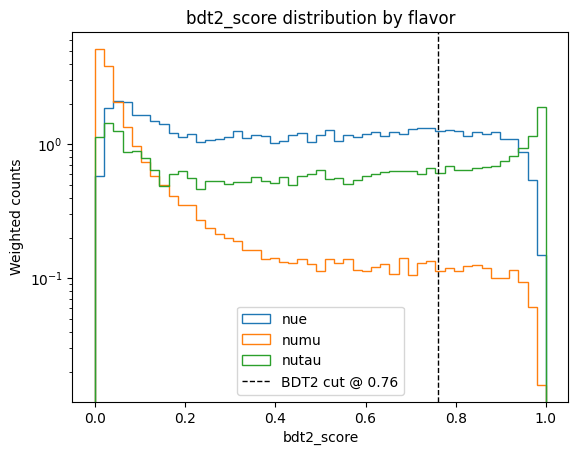

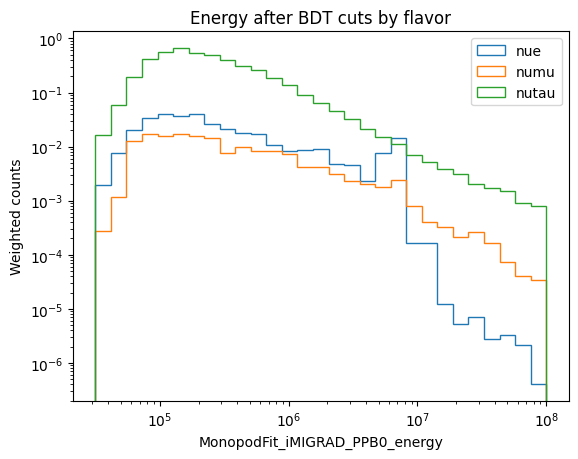


Final purity: 0.901, efficiency: 0.133


In [12]:
df2_with_scores = prediction_flow(
    df_2,
    models,
    features,
    thresholds=thresholds
)

summary = evaluation_flow(
    df2_with_scores, 
    model1 = bdt1,
    model2 = bdt2, 
    features = features,
    weight_col = 'weight',
    precut_criteria={},
    purity_target=0.90,
    output_dir=f'{output_dir}/eval2_model1'
)

In [20]:
import matplotlib.pyplot as plt
import numpy as np

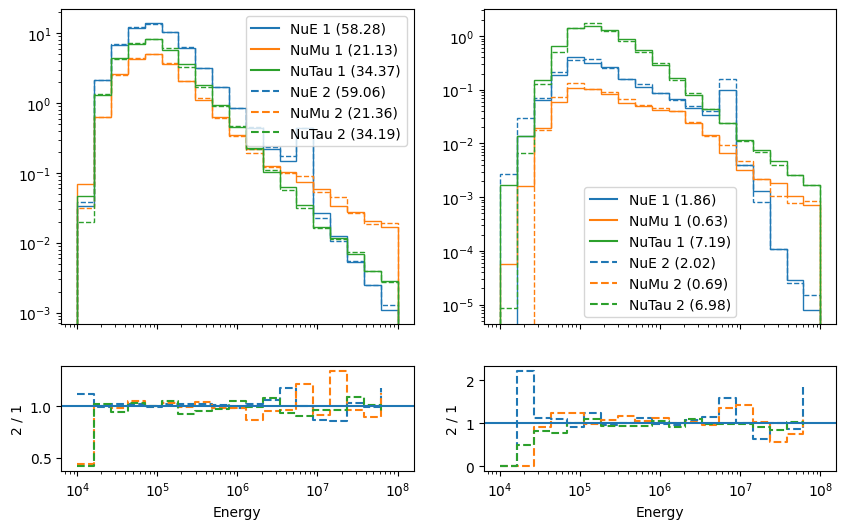

In [ ]:
bins = np.geomspace(1e4, 1e8, 20)

fig, axs = plt.subplots(2, 2, sharex="col", gridspec_kw={"height_ratios": [3, 1]}, figsize=(10, 6))

flavors = [("NuE", 12, "C0"), ("NuMu", 14, "C1"), ("NuTau", 16, "C2")]

for lab, pid, col in flavors:
    axs[0,0].hist(df1_with_scores.loc[abs(df1_with_scores.MCPrimaryType) == pid, "MonopodFit_iMIGRAD_PPB0_energy"], bins=bins, weights=df1_with_scores.loc[abs(df1_with_scores.MCPrimaryType) == pid, "weight"], histtype="step", color=col, linestyle="-", label=lab)
    axs[0,0].hist(df2_with_scores.loc[abs(df2_with_scores.MCPrimaryType) == pid, "MonopodFit_iMIGRAD_PPB0_energy"], bins=bins, weights=df2_with_scores.loc[abs(df2_with_scores.MCPrimaryType) == pid, "weight"], histtype="step", color=col, linestyle="--")

for lab, pid, col in flavors:
    h1, _ = np.histogram(df1_with_scores.loc[abs(df1_with_scores.MCPrimaryType) == pid, "MonopodFit_iMIGRAD_PPB0_energy"], bins=bins, weights=df1_with_scores.loc[abs(df1_with_scores.MCPrimaryType) == pid, "weight"])
    h2, _ = np.histogram(df2_with_scores.loc[abs(df2_with_scores.MCPrimaryType) == pid, "MonopodFit_iMIGRAD_PPB0_energy"], bins=bins, weights=df2_with_scores.loc[abs(df2_with_scores.MCPrimaryType) == pid, "weight"])
    axs[1,0].step(bins[:-1], np.divide(h2, h1, where=h1 > 0), where="post", color=col, linestyle="--")

axs[0,0].legend()

cut1 = df1_with_scores.query("bdt1_score > 0.33 and bdt2_score > 0.5")
cut2 = df2_with_scores.query("bdt1_score > 0.33 and bdt2_score > 0.5")

for lab, pid, col in flavors:
    axs[0,1].hist(cut1.loc[abs(cut1.MCPrimaryType) == pid, "MonopodFit_iMIGRAD_PPB0_energy"], bins=bins, weights=cut1.loc[abs(cut1.MCPrimaryType) == pid, "weight"], histtype="step", color=col, linestyle="-", label=lab)
    axs[0,1].hist(cut2.loc[abs(cut2.MCPrimaryType) == pid, "MonopodFit_iMIGRAD_PPB0_energy"], bins=bins, weights=cut2.loc[abs(cut2.MCPrimaryType) == pid, "weight"], histtype="step", color=col, linestyle="--")

for lab, pid, col in flavors:
    h1, _ = np.histogram(cut1.loc[abs(cut1.MCPrimaryType) == pid, "MonopodFit_iMIGRAD_PPB0_energy"], bins=bins, weights=cut1.loc[abs(cut1.MCPrimaryType) == pid, "weight"])
    h2, _ = np.histogram(cut2.loc[abs(cut2.MCPrimaryType) == pid, "MonopodFit_iMIGRAD_PPB0_energy"], bins=bins, weights=cut2.loc[abs(cut2.MCPrimaryType) == pid, "weight"])
    axs[1,1].step(bins[:-1], np.divide(h2, h1, where=h1 > 0), where="post", color=col, linestyle="--")

axs[1,0].axhline(1)
axs[1,1].axhline(1)

axs[0,1].legend()
axs[0,0].set_yscale("log")
axs[0,1].set_yscale("log")
axs[0,0].set_xscale("log")
axs[0,1].set_xscale("log")
axs[1,0].set_xscale("log")
axs[1,1].set_xscale("log")

axs[1,0].set_ylabel("2 / 1")
axs[1,1].set_ylabel("2 / 1")
axs[1,0].set_xlabel("Energy")
axs[1,1].set_xlabel("Energy")

from matplotlib.lines import Line2D

rates_left_1 = {lab: df1_with_scores.loc[abs(df1_with_scores.MCPrimaryType) == pid, "weight"].sum() for lab, pid, _ in flavors}
rates_left_2 = {lab: df2_with_scores.loc[abs(df2_with_scores.MCPrimaryType) == pid, "weight"].sum() for lab, pid, _ in flavors}
rates_right_1 = {lab: cut1.loc[abs(cut1.MCPrimaryType) == pid, "weight"].sum() for lab, pid, _ in flavors}
rates_right_2 = {lab: cut2.loc[abs(cut2.MCPrimaryType) == pid, "weight"].sum() for lab, pid, _ in flavors}

handles_left = [Line2D([0],[0], color=col, linestyle="-", label=f"{lab} 1 ({rates_left_1[lab]:.2f})") for lab, _, col in flavors] + \
               [Line2D([0],[0], color=col, linestyle="--", label=f"{lab} 2 ({rates_left_2[lab]:.2f})") for lab, _, col in flavors]

handles_right = [Line2D([0],[0], color=col, linestyle="-", label=f"{lab} 1 ({rates_right_1[lab]:.2f})") for lab, _, col in flavors] + \
                [Line2D([0],[0], color=col, linestyle="--", label=f"{lab} 2 ({rates_right_2[lab]:.2f})") for lab, _, col in flavors]

axs[0,0].legend(handles=handles_left)
axs[0,1].legend(handles=handles_right)

compare the roc curves

In [ ]:
import matplotlib.pyplot as plt

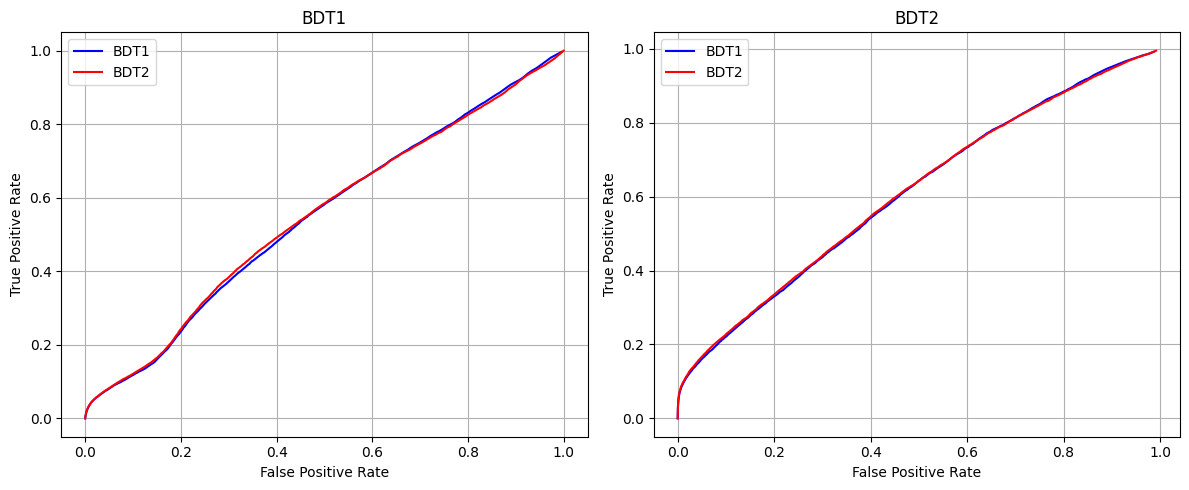

In [29]:
# Read CSVs
zheyang_path = "/data/user/tvaneede/GlobalFit/reco_processing/bdt/notebooks/optimize_bdt/combine_datasets/eval2_model1/"
roc1_zheyang = pd.read_csv( zheyang_path + "roc_curve1.csv" )
roc2_zheyang = pd.read_csv( zheyang_path + "roc_curve2.csv" )

thijs_path = "/data/user/tvaneede/GlobalFit/reco_processing/bdt/notebooks/optimize_bdt/combine_datasets/eval1_model1/"
roc1_thijs = pd.read_csv( thijs_path + "roc_curve1.csv" )
roc2_thijs = pd.read_csv( thijs_path + "roc_curve2.csv" )

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot first iteration
axes[0].plot(roc1_zheyang['fpr'], roc1_zheyang['tpr'], label='BDT1', color='blue')
axes[0].plot(roc1_thijs['fpr'], roc1_thijs['tpr'], label='BDT2', color='red')
axes[0].set_title('BDT1')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend()
axes[0].grid(True)

# Plot second iteration
axes[1].plot(roc2_zheyang['fpr'], roc2_zheyang['tpr'], label='BDT1', color='blue')
axes[1].plot(roc2_thijs['fpr'], roc2_thijs['tpr'], label='BDT2', color='red')
axes[1].set_title('BDT2')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

They are very very comparable!

Lets create my own ROC curve

In [48]:
from sklearn.metrics import roc_curve as sk_roc_curve, auc
import numpy as np

def roc_curve_points(df, sig_label, bg_label, score_label, weight="weight"):
    y_true = np.r_[np.ones(df[sig_label].sum()), np.zeros(df[bg_label].sum())]
    y_score = np.r_[df.loc[df[sig_label], score_label].values,
                    df.loc[df[bg_label], score_label].values]
    if weight is None: 
        weights = np.ones(len(y_true))
    else:
        weights = np.r_[df.loc[df[sig_label], weight].values,
                        df.loc[df[bg_label], weight].values]
    fpr, tpr, _ = sk_roc_curve(y_true, y_score, sample_weight=weights)
    return fpr, tpr, auc(fpr, tpr)


In [41]:
df = annotate_labels( df1_with_scores )

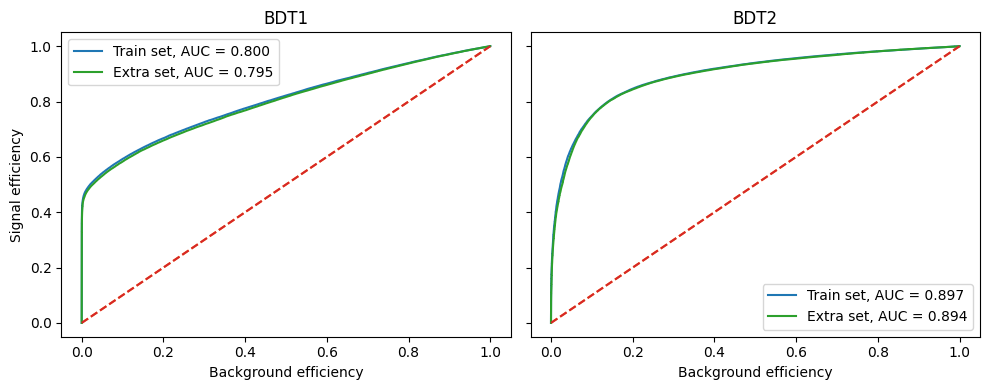

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for weight in [None]:
    for label,df_with_score in zip(["Train set", "Extra set"],[df1_with_scores, df2_with_scores]):
        df = annotate_labels( df_with_score )
        fpr1, tpr1, auc1 = roc_curve_points(df, "sig_bdt1", "bg_bdt1", "bdt1_score", weight)
        axs[0].plot(fpr1, tpr1, label=f"{label}, AUC = {auc1:.3f}")
        axs[0].plot([0, 1], [0, 1], linestyle="--")
        axs[0].set_title("BDT1")
        axs[0].set_xlabel("Background efficiency")
        axs[0].set_ylabel("Signal efficiency")
        axs[0].legend()

        fpr2, tpr2, auc2 = roc_curve_points(df, "sig_bdt2", "bg_bdt2", "bdt2_score", weight)
        axs[1].plot(fpr2, tpr2, label=f"{label}, AUC = {auc2:.3f}")
        axs[1].plot([0, 1], [0, 1], linestyle="--")
        axs[1].set_title("BDT2")
        axs[1].set_xlabel("Background efficiency")
        axs[1].legend()

plt.tight_layout()
plt.savefig(f"{output_dir}/compare_roc_train_test_set.png")
plt.show()
